# TopoCluster Regression

This is a simple, stripped-down notebook for training networks. I've removed most of the models that are present in `TopoClusterRegressionRewrite.ipynb`, as well as most of the plots (I find that the multitude of plots makes things a bit cumbersome and hard to navigate -- I'll see if I can change the way they are displayed later on).

Here, we train a number of different models -- by only running certain cells, you can choose which to train and evaluate.

#### 1) Initial setup

In [1]:
# ML fitting/loading/saving settings
overwriteModel = False # If true, force training. If false, load the specified model if it already exists.

finishTraining = False

Now let's choose our training data (and associated strategy).

In [2]:
# training data choice
# options are jet, pion, pion_reweighted

# options are:
#   - pion_legacy
#   - pion
#   - pion_reweighted

source = 'pion'
subdir = 'pion1' # name for subdir holding models/plots

In [3]:
# Import some basic libraries.
import sys, os, uuid, glob, pickle, pathlib
import numpy as np
import pandas as pd # we will use some uproot/pandas interplay here.
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt # used for plotting
#import joblib as jl # for saving scalers
from numba import jit

# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu
from util import io_util         as iu

# Custom tensorflow.keras callbacks
from util.keras.callbacks import GetCallbacks

# Regression-specific utils
from util.regression import data_util as rdu
from util.regression import plot_util as rpu
from util.regression import training_util as rtu

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = path_prefix + 'regression/Plots/{}/'.format(subdir)
modelpath = path_prefix + 'regression/Models/{}/'.format(subdir)
paths = [plotpath, modelpath]
for path in [plotpath, modelpath]:
    try: os.makedirs(path)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/00


In [4]:
# fancy display names for each pion type
pi_latex = {
    'p0': '\(\pi^{0}\)',
    'pp': '\(\pi^{\pm}\)',
}
pi_text = {
    'p0': 'pi0',
    'pp': 'pi+/-'
}

# Plotting settings
# xkcd -- turn this on for fun-looking (but marginally less useful) plots
use_xkcd = False
if(use_xkcd):
    mode = 'light'
    plt.xkcd(scale=.75,length=100,randomness=1)
    
# plotting style -- manages our color palette and object colors
mode = 'dark' # for publications, use "light"
plotstyle = qu.PlotStyle(mode)
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

#### 2) Get the data.

Let me lay out some definitions, so it's clear as to what the data is.

We have a number of different "strategies" (the `source` variable at the top). These correspond to different choices of training, validation and testing datasets.

1. `pion`: We train and validate the network using our single pion data.

2. `pion_legacy`: We train and validate using our old, noise-free single pion data.

3. `pion_reweighted`: This is the same as `pion`, except that our training data is reweighted using a jet dataset (via their reco topo-cluster $p_T$ distributions), that corresponds with QCD dijet events.

The validation performed for these networks is effectively being done on some "holdout" dataset from training -- it will by definition have similar kinematics, being drawn from the same set of events. The more interesting test -- how our energy regression performs in tandem with classification on our *unlabeled* jet dataset, will be handled in a separate notebook.

In [5]:
if(source == 'pion_legacy'):
    inputpath = path_prefix+'data/pion_legacy/'
    rootfiles = {
        'p0':inputpath + 'pi0.root',
        'pp':inputpath + 'pi[pm]*.root'
    }
    
    branches = ['clusterE', 'clusterPt', 'clusterEta', 'cluster_ENG_CALIB_TOT']

elif(source == 'pion' or source == 'pion_reweighted'):
    inputpath=path_prefix+'data/pion/'
    rootfiles = {        
        'p0':inputpath + 'user.mswiatlo.900246.PG_singlepi0_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root',
        'pp':inputpath + 'user.mswiatlo.900247.PG_singlepion_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root'
    }
    
    branches = ['cluster_E', 'cluster_Pt', 'cluster_Eta', 'cluster_ENG_CALIB_TOT']

else: assert(False)

In [6]:
# Prepare data
h5_name_suffix = 'tdata'
h5_name = inputpath + h5_name_suffix

pdata,pcells = mu.setupPionData(
    rootfiles, 
    branches=branches, 
    layers=layers, 
    balance_data=True, 
    n_max = 300000,
    verbose=True,
    load=True,
    save=True,
    filename=h5_name,
    match_distribution='cluster_ENG_CALIB_TOT',
    match_binning = (20000,0.,2000.),
    cut_distributions=['cluster_ENG_CALIB_TOT','clusterEta'],
    cut_values = [.2, (-0.7,0.7)],
    cut_types=['lower','window']
)

total = np.sum([len(x) for x in pdata.values()],dtype=int)
for key,frame in pdata.items():
    n = len(frame)
    print("Number of {a:<7} events: {b:>10}\t({c:.1f}%)".format(a=pi_text[key], b = n, c = 100. * n / total))
print("Total: {}".format(total))

# Create/get training/validation/testing indices.
pdata = rdu.DataPrep(pdata,
                     trainfrac=0.7,
                     filename=h5_name
                    )

Loading pandas DataFrame and calo images from /local/home/jano/ml4pions/LCStudies/regression/../data/pion/tdata_frame.h5 and /local/home/jano/ml4pions/LCStudies/regression/../data/pion/tdata_images.h5.
Number of pi0     events:     300000	(50.0%)
Number of pi+/-   events:     300000	(50.0%)
Total: 600000
Loading indices for key p0 from /local/home/jano/ml4pions/LCStudies/regression/../data/pion/tdata_indices.h5.
Loading indices for key pp from /local/home/jano/ml4pions/LCStudies/regression/../data/pion/tdata_indices.h5.


### Defining regression variables

Beyond the information already present in the data, we may want to pre-compute some extra regression inputs.

The difference between computing them here, on the whole dataset, versus doing it in batch as part of the network itself, is that we can also define some `scalers` based on these variables. This will allow us to scale them across the dataset, for example to get them into the interval of \[0,1\].

In [7]:
m = 1.
b = 1.
EnergyMapping = iu.LinLogMapping(b=b,m=m)

In [8]:
# # Perform a test of our mapping to demonstrate its numerical stability
# # TODO: Fix legend sizing, it is flaky (and needs re-running)
# x=np.linspace(-10.,10.,10000)
# b_vals=[1.,10.,1.0e14]
# m_vals=[1.]
# iu.MapStabilityTest(iu.LogMapping, b_vals=b_vals, m_vals=m_vals, x=x, ps=plotstyle, savedir=plotpath, legend_size=10)

It looks like our `LinLogMapping` is pretty numerically stable as long as $b \gg m$. I think this is the expected behaviour, given the instabilities with logarithms that we've seen before.

In [9]:
# Some regression vars.
# Note that the mapping functions can probably be sped up with numba, but might throw errors during plotting above. Need to look into this.
for key,frame in pdata.items():
    frame['logE'] = EnergyMapping.Forward(frame['clusterE'].to_numpy())
    frame['logECalib'] = EnergyMapping.Forward(frame['cluster_ENG_CALIB_TOT'].to_numpy())
    frame['clusterEtaAbs'] = np.abs(frame['clusterEta'].to_numpy())

In [10]:
scaler_file = modelpath + 'scalers.save'
scaler_branches = ['logE','logECalib','clusterEtaAbs']
scalers = mu.setupScalers(pdata, scaler_branches, scaler_file)

Loading scalers from /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion1/scalers.save.


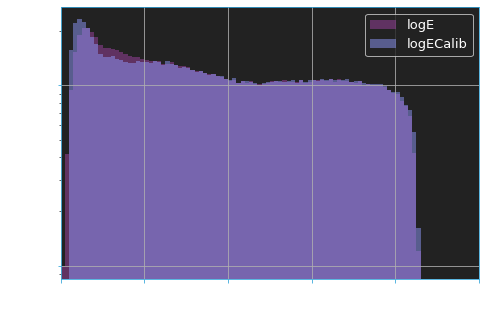

In [11]:
# Let's make a histogram of the regression vars, before scaling.
fig, ax = plt.subplots(1,1,figsize=(7.5,5))
labels = ['logE','logECalib']
rvars = [np.concatenate([frame[x].to_numpy() for frame in pdata.values()]) for x in labels]

pu.histogramOverlay(ax, rvars, labels, 'x', 'y',
                    x_min = 0., x_max = 10., xbins = 100,
                    normed = True, y_log = True,
                    ps = plotstyle
                   )
plt.show()

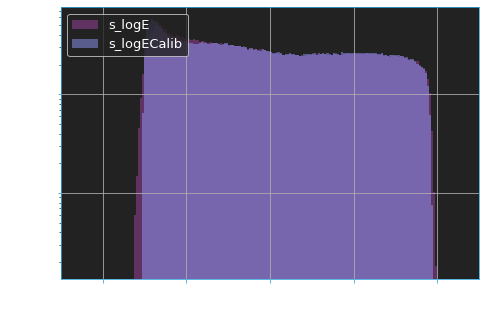

In [12]:
# Let's make a histogram of the regression vars, after scaling.
fig, ax = plt.subplots(1,1,figsize=(7.5,5))
labels = ['s_logE','s_logECalib']
rvars = [np.concatenate([frame[x].to_numpy() for frame in pdata.values()]) for x in labels]

pu.histogramOverlay(ax, rvars, labels, 'x', 'y',
                    x_min = -2.5, x_max = 2.5, xbins = 200,
                    normed = True, y_log = True,
                    ps = plotstyle
                   )
plt.show()

We may optionally perform some re-weighting of our training events. If using the `pion_reweighted` strategy, we will re-weight our single-pion training data to match the topo-cluster $p_T$ spectrum of our jet data.

In [13]:
# TODO: consider re-adding some sample weighting schemes
sample_weights = {
    key: np.full(np.sum(frame['train'].to_numpy()),1.)
    for key,frame in pdata.items()
}

## Tensorflow/Keras Prep

In this workflow we have the ability to train a number of models -- some will require additional data setup. Here, we have some basic setup they will all use.

In [14]:
models = {} # keep track of the models -- note that we train multiple instances of each model
histories = {} # keep track of histories of the models we train
regressors = {} # keep track of the trained models (will be KerasRegressor objects)
energy_names = {} # keep track of the names of regressed variables

model_filename_suffixes = {
    'pp':'_charged',
    'p0':'_neutral'
}

energy_name_prefix = 'clusterE_pred_'

#from keras.wrappers.scikit_learn import KerasRegressor # scikit_learn wrapper -- why do we use this, vs. native tf.keras approach like in classification notebook?
#from tensorflow.keras.models import load_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

#from util.regression.models import baseline_nn_All_model, simple_dnn, resnet, resnet_wide
from util.regression.models import baseline_nn_model, depth_network, split_emb_cnn, resnet

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


Here's some additional input preparation that we will need for some of our networks.

In [ ]:
# Prepare the data.
All_input = rdu.CombinedInput(pdata,
                              pcells,
                              branches = ['s_logE','s_clusterEtaAbs']
                             )

## Training "all" model

Here we train a simple, fully-connected neural network that uses the calorimeter cells as input, along with reco energy and $\eta$.

In [ ]:
print('Baseline model.')
# Baseline model
model_key = 'all'
energy_names[model_key] = energy_name_prefix + model_key
lr = 1e-5
decay = 0. # lr decay *within* each epoch 1e-6
gamma = .1 # lr decay between epochs (via scheduler)
min_delta = 0.0005
patience = 5
dropout = -1. # < 0 -> no dropout
models[model_key] = baseline_nn_model(strategy, lr=lr, decay=decay, dropout=dropout)

# Set our training hyper-parameters.
batch_size = 200 * ngpu
epochs = 100
verbose = 1
regressors[model_key] = {}
histories[model_key] = {}

# Load/train the models, and evaluate them on all the data.
for key in All_input.keys():
    
    tidx = pdata[key]['train']
    vidx = pdata[key]['val'] 
    
    model_dir = ''.join([modelpath, model_key])
    model_filename = '{}/{}{}.h5'.format(model_dir,model_key,model_filename_suffixes[key])

    regressors[model_key][key], histories[model_key][key] = rtu.TrainNetwork(
        model=models[model_key],
        modelfile = model_filename,
        x_train = All_input[key][tidx],
        y_train = pdata[key]['s_logECalib'][tidx],
        x_valid = All_input[key][vidx],
        y_valid = pdata[key]['s_logECalib'][vidx],
        sample_weight=sample_weights[key],
        callbacks = GetCallbacks(model_filename, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        overwriteModel=overwriteModel,
        finishTraining=finishTraining
    )
    
    # Get predictions for all the data.
    pdata[key][energy_names[model_key]] = EnergyMapping.Inverse(scalers[key]['logECalib'].inverse_transform(regressors[model_key][key].predict(All_input[key])))

## Training "simple" model

Here we train another simple, fully-connected neural network that uses reco energy and $\eta$ as input, along with depth information (vector of integrals of calorimeter images).

In [ ]:
# Prepare the data.
All_input = rdu.DepthInput(pdata,
                           pcells,
                           branch_map = {
                               's_logE':'energy',
                               's_clusterEtaAbs':'eta'
                           }
                          )
Split_input = rdu.DictionarySplit(All_input, pdata)
train_input, valid_input = Split_input['train'], Split_input['val']

In [ ]:
print('Depth-based model.')
# Simple model
model_key = 'simple'
energy_names[model_key] = energy_name_prefix + model_key
lr = 5e-5 # 1e-4
decay = 0. # lr decay *within* each epoch 1e-6
gamma = .1 # lr decay between epochs (via scheduler)
min_delta = 0.0005
patience = 5
dropout = -1. # < 0 -> no dropout
models[model_key] = depth_network(strategy, lr=lr, decay=decay, dropout=dropout)
#print(models[model_key]().summary())

# Set our training hyper-parameters.
batch_size = 200 * ngpu
epochs = 100
verbose = 1
regressors[model_key] = {}
histories[model_key] = {}

# Load/train the models, and evaluate them on all the data.
for key in All_input.keys():
    
    tidx = pdata[key]['train']
    vidx = pdata[key]['val']  
    
    model_dir = ''.join([modelpath, model_key])
    model_filename = '{}/{}{}.h5'.format(model_dir,model_key,model_filename_suffixes[key])

    regressors[model_key][key], histories[model_key][key] = rtu.TrainNetwork(
        model=models[model_key],
        modelfile = model_filename,
        x_train = train_input[key],
        y_train = pdata[key]['s_logECalib'][tidx],
        x_valid = valid_input[key],
        y_valid = pdata[key]['s_logECalib'][vidx],
        sample_weight=sample_weights[key],
        callbacks = GetCallbacks(model_filename, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        overwriteModel=overwriteModel,
        finishTraining=finishTraining
    )
    
    # Get predictions for all the data.
    pdata[key][energy_names[model_key]] = EnergyMapping.Inverse(scalers[key]['logECalib'].inverse_transform(regressors[model_key][key].predict(All_input[key])))

## Split EMB CNN

We can train a CNN model that's inspired by one of our well-performing CNN classifiers. It groups the 6 calo layers as EMB1, EMB2+EMB3, and TileBar0+TileBar1+TileBar2. Compared to the classifier, we've removed a few convolutions to make it a little simpler, and have added in energy and abs(eta) information.

In [15]:
# Prepare the data.
All_input = rdu.ResnetInput(pdata,
                            pcells,
                            branch_map = {
                                's_logE':'energy',
                                's_clusterEtaAbs':'eta'
                            }
)
Split_input = rdu.DictionarySplit(All_input, pdata)
train_input, valid_input = Split_input['train'], Split_input['val']

In [16]:
print('"Split EMB" CNN model.')
# CNN
model_key = 'split_emb_cnn'
energy_names[model_key] = energy_name_prefix + model_key
lr = 5e-5
decay = 0. # lr decay *within* each epoch
dropout = 0.2
gamma = .1 # lr decay between epochs (via scheduler)
min_delta = 0.0005
patience = 5
augmentation = True # whether or not to augment data during training, by flipping in eta & phi

models[model_key] = split_emb_cnn(lr=lr, decay=decay, dropout=dropout, augmentation=True)

# Set our training hyper-parameters.
batch_size = 200 * ngpu
epochs = 100 # 100
verbose = 1
regressors[model_key] = {}
histories[model_key] = {}

# Load/train the models, and evaluate them on all the data.
for key in All_input.keys():
    
    tidx = pdata[key]['train']
    vidx = pdata[key]['val']  
    
    model_dir = ''.join([modelpath, model_key])
    model_filename = '{}/{}{}.h5'.format(model_dir,model_key,model_filename_suffixes[key])

    regressors[model_key][key], histories[model_key][key] = rtu.TrainNetwork(
        model=models[model_key],
        modelfile = model_filename,
        x_train = train_input[key],
        y_train = pdata[key]['s_logECalib'][tidx],
        x_valid = valid_input[key],
        y_valid = pdata[key]['s_logECalib'][vidx],
        sample_weight=sample_weights[key],
        callbacks = GetCallbacks(model_filename, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        overwriteModel=overwriteModel,
        finishTraining=finishTraining
    )
    
    # Get predictions for all the data.
    pdata[key][energy_names[model_key]] = EnergyMapping.Inverse(scalers[key]['logECalib'].inverse_transform(regressors[model_key][key].predict(All_input[key])))

"Split EMB" CNN model.
Epoch 1/100
1050/1050 [==============================] - 18s 17ms/step - loss: 0.4026 - mae: 0.4928 - mse: 0.4026 - val_loss: 0.2007 - val_mae: 0.3502 - val_mse: 0.2007 - lr: 5.0000e-05
Epoch 2/100
1050/1050 [==============================] - 16s 16ms/step - loss: 0.1682 - mae: 0.3145 - mse: 0.1682 - val_loss: 0.0855 - val_mae: 0.2260 - val_mse: 0.0855 - lr: 4.5242e-05
Epoch 3/100
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0735 - mae: 0.2068 - mse: 0.0735 - val_loss: 0.0223 - val_mae: 0.1158 - val_mse: 0.0223 - lr: 4.0937e-05
Epoch 4/100
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0329 - mae: 0.1388 - mse: 0.0329 - val_loss: 0.0055 - val_mae: 0.0528 - val_mse: 0.0055 - lr: 3.7041e-05
Epoch 5/100
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0230 - mae: 0.1165 - mse: 0.0230 - val_loss: 0.0035 - val_mae: 0.0403 - val_mse: 0.0035 - lr: 3.3516e-05
Epoch 6/100
1050/1050 [========================

## ResNet

We can also train an implementation of ResNet. More precisely, we use a ResNet model on the calorimeter images, and then mix in the energy and $\eta$ at the output layer.

In [ ]:
# Prepare the data.
All_input = rdu.ResnetInput(pdata,
                            pcells,
                            branch_map = {
                                's_logE':'energy',
                                's_clusterEtaAbs':'eta'
                            }
)
Split_input = rdu.DictionarySplit(All_input, pdata)
train_input, valid_input = Split_input['train'], Split_input['val']

In [ ]:
print('ResNet.')
# Resnet
model_key = 'resnet'
energy_names[model_key] = energy_name_prefix + model_key
lr = 1e-6
decay = 0. # lr decay *within* each epoch 1e-6
gamma = .1 # lr decay between epochs (via scheduler)
min_delta = 0.0005
patience = 5
channels = 6
filter_sets = [
    [64,64,256],
    [128,128,512]
    #[256,256,1024],
    #[512,512,2048]
]         
f_vals = [3,3] # [3,3,3,3] sizes of filters in middle of conv/identity blocks
s_vals = [1,2] # [1,2,2,2] strides for each convolutional block
i_vals = [2,3] # [2,3,5,2] number of identity blocks per stage
input_shape = (128,16)
augmentation = True # whether or not to augment data during training, by flipping in eta & phi

models[model_key] = resnet(lr=lr, channels=channels, filter_sets=filter_sets, f_vals=f_vals, s_vals=s_vals, i_vals=i_vals, decay=decay, input_shape=input_shape, augmentation=augmentation)

# Set our training hyper-parameters.
batch_size = 200 * ngpu
epochs = 200 # 200
verbose = 1
regressors[model_key] = {}
histories[model_key] = {}

# Load/train the models, and evaluate them on all the data.
for key in All_input.keys():
    
    tidx = pdata[key]['train']
    vidx = pdata[key]['val']  
    
    model_dir = ''.join([modelpath, model_key])
    model_filename = '{}/{}{}.h5'.format(model_dir,model_key,model_filename_suffixes[key])

    regressors[model_key][key], histories[model_key][key] = rtu.TrainNetwork(
        model=models[model_key],
        modelfile = model_filename,
        x_train = train_input[key],
        y_train = pdata[key]['s_logECalib'][tidx],
        x_valid = valid_input[key],
        y_valid = pdata[key]['s_logECalib'][vidx],
        sample_weight=sample_weights[key],
        callbacks = GetCallbacks(model_filename, append=True, use_decay=True, gamma=gamma, min_delta=min_delta, patience=patience), 
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        overwriteModel=overwriteModel,
        finishTraining=finishTraining
    )
    
    # Get predictions for all the data.
    pdata[key][energy_names[model_key]] = EnergyMapping.Inverse(scalers[key]['logECalib'].inverse_transform(regressors[model_key][key].predict(All_input[key])))

## ResNet Mini

In an effort to simplify our ResNet -- and get it to train faster -- we can consider just using a single channel for our images, or some subset of channels. We can re-use the input we prepared for our full ResNet, though we'll only need a portion of it. Note that if we only use a single channel, the rescaling (via `input_shape`) is redundant, and we should just set that to the original dimensions (and, in practice, remove the scaling entirely if we stick with just one channel).

**TODO:** Reimplement this.

## Plotting results (testing how well our network works)

Now, let's plot some kinematics and network results. We'll make two groups of plots -- one for charged pions and one for neutral pions.

Within each group of plots, we'll make two plots for each quantity -- one made using just the training data, and then one made using all the data (training + whatever we excluded -- but still excluding events with `cluster_ENG_CALIB_TOT` $< 0$ since these blow up network output).

In [ ]:
# for convenience below
training_frames = {key:frame[frame['train']] for key,frame in pdata.items()}
validation_frames = {key:frame[frame['val']] for key,frame in pdata.items()}

In [ ]:
for model_key in energy_names.keys():
    results = rpu.EnergySummary(
        train_dfs=training_frames, 
        valid_dfs=validation_frames, 
        data_dfs=pdata, 
        energy_name=energy_names[model_key], 
        model_name=model_key, 
        plotpath=plotpath, 
        extensions=['png'], 
        plot_size=750, 
        strat='pion', 
        full=False,
        ps=plotstyle
    )
    for canv in results['canv'].values(): canv.Draw()

In [ ]:
# Making graphs of the network models
from tensorflow.keras.utils import plot_model

for model_key in regressors.keys():
    for key,reg in regressors[model_key].items():
        graph_name = '{}{}_{}.png'.format(plotpath,model_key,key)
        plot_model(reg.model, graph_name, show_shapes=True, rankdir='LR', dpi=400)

In [ ]:
import matplotlib.pyplot as plt
# Make plots of mse and mae for training and validation (if present)

for model_key in histories.keys():
    for dkey in histories[model_key].keys():
    
        dname = dkey
        
        epochs = len(histories[model_key][dkey]['mae'])
        epoch_ticks = epochs
        if(epoch_ticks > 10): epoch_ticks = epoch_ticks/2
        x = np.arange(epochs) + 1
        fig, ax = plt.subplots(1,2,figsize=(15,5))
    
        keys = ['mae','val_mae']
        lines = [histories[model_key][dkey][key] for key in keys]
        pu.multiplot_common(ax[0], x,lines, keys, y_min=1.0e-3, y_max=10., y_log=True, x_ticks=epoch_ticks, xlabel = 'Epoch', ylabel = 'MAE', title='Mean Avg. Error for {} ({})'.format(model_key,dname), ps=plotstyle)
    
        keys = ['mse','val_mse']
        lines = [histories[model_key][dkey][key] for key in keys]
        pu.multiplot_common(ax[1], x,lines, keys, y_min=1.0e-3, y_max=10., y_log=True, x_ticks=epoch_ticks, xlabel = 'Epoch', ylabel = 'MSE', title='Mean Sq. Error for {} ({})'.format(model_key,dname), ps=plotstyle)
    
        # add grids
        for axis in ax.flatten():
            axis.grid(True,color=plotstyle.grid_plt)

        qu.SaveSubplots(fig, ax, ['mae_{}_{}'.format(model_key,dkey), 'mse_{}_{}'.format(model_key,dkey)], savedir=plotpath)
        plt.show()